# Clean the data

Once we know the basic data sctructure, we have to clean it, so we can use it for other purposes such as analyis or even predective tasks.

In this notebook we cover a basic data cleaning pipeline where we are going to deal with different problems:

- Joining the different data files: We need to join all the files in a single csv so the posterior analysis is simplier.
- Removing NaNs columns: Having a lot of data is nice, but usually, dealing with those large amounts of records also generates unconsistent data. Removing the NaN values we will improve the data consistency and hence the data value.

In [63]:
import json
import requests
from pathlib import Path

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [64]:
DATA_PATH = Path('../data/raw/')

## Joining the data

First of all, we need to know which files it will be merge into the same DataFrame.

In [65]:
list(DATA_PATH.glob('*.json'))

[WindowsPath('../data/raw/Barna_rent.json'),
 WindowsPath('../data/raw/Girona_rent.json'),
 WindowsPath('../data/raw/Lleida_rent.json'),
 WindowsPath('../data/raw/Madrid_rent.json'),
 WindowsPath('../data/raw/Malaga_rent.json'),
 WindowsPath('../data/raw/Mallorca_rent.json'),
 WindowsPath('../data/raw/Tarragona_rent.json'),
 WindowsPath('../data/raw/Valencia_rent.json'),
 WindowsPath('../data/raw/Zaragoza_rent.json')]

Then, we will merge the data into a unique DataFrame because we know that all these data have the same json format.

In [66]:
def city_name_from_path(p):
    return p.stem.split('_')[0]

df = pd.DataFrame()

for f in DATA_PATH.glob('*.json'):
    jdata = json.load(f.open())
    current_df = pd.json_normalize(jdata, sep='_')
    current_df['spain_state'] = city_name_from_path(f)
    df = df.append(current_df)

df.head()

,propertyCode,thumbnail,externalReference,numPhotos,floor,price,propertyType,operation,size,exterior,...,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,detailedType_subTypology,parkingSpace_parkingSpacePrice,newDevelopmentFinished,spain_state
0,88707408,https://img3.idealista.com/blur/WEB_LISTING/0/...,AL_Sants,18,3,1050.0,flat,rent,50.0,True,...,False,flat,"Sants, Barcelona","Piso en Calle de Sants, 208",NaN,NaN,NaN,NaN,NaN,Barna
1,90050445,https://img3.idealista.com/blur/WEB_LISTING/0/...,AB1508007-1,13,5,3000.0,flat,rent,170.0,True,...,False,flat,"Pedralbes, Barcelona",Piso en Avenida Diagonal,True,True,NaN,NaN,NaN,Barna
2,89790054,https://img3.idealista.com/blur/WEB_LISTING/0/...,CB_BCN_0286_A,17,4,1050.0,flat,rent,75.0,True,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Piso en Calle del Comandant Benítez,NaN,NaN,NaN,NaN,NaN,Barna
3,89813394,https://img3.idealista.com/blur/WEB_LISTING/0/...,CREA1105,16,3,780.0,studio,rent,36.0,True,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Estudio,NaN,NaN,studio,NaN,NaN,Barna
4,90050238,https://img3.idealista.com/blur/WEB_LISTING/0/...,6977 OBG,14,1,725.0,flat,rent,65.0,True,...,False,flat,"Sant Ildefons, Cornellà de Llobregat",Piso en boix,NaN,NaN,NaN,NaN,NaN,Barna


Note that as we were appending the multiple dataframes, we were generating a new `spain_state` column. This will be pretty handy later because we are going to perform statistics regarding to the flats' state.

As we can see on the previous table, each line contains NaN values, it could be produced because one flat doesn't have a parking space or something like that.

In [67]:
print('Rows containing NaN:', df.isna().any(axis=1).sum())

Rows containing NaN: 9974


## Removing NaNs

To start removing NaNs values is always a good idea to know which columns contain those undesired values.

In [68]:
df.isna().any(0)

propertyCode                                  False
thumbnail                                      True
externalReference                              True
numPhotos                                     False
floor                                          True
price                                         False
propertyType                                  False
operation                                     False
size                                          False
exterior                                      False
rooms                                         False
bathrooms                                     False
address                                       False
province                                      False
municipality                                  False
district                                       True
country                                       False
neighborhood                                   True
latitude                                      False
longitude   

In [69]:
print('Number of columns that contain NaNs:', df.isna().any(0).sum())

Number of columns that contain NaNs: 12


Only 12 columns out of 40 contain NaNs values.

In the following subsections, we are going to remove the NaNs for each column and explaining why we decided to remove, replace or keep the NaN values.

### Thumbnail NaNs

Thumbnail is the phtoto that users see while they are scrolling a search on the idealista web page. Setting a good Thumbnail is determining success factor to rent or sell your announced flat, home or whatever. Therefore we expect few NaNs on this column. 

In [70]:
print(f'Thumbnail NaNs are {df.thumbnail.isna().sum()} out of {df.shape[0]} rows')

Thumbnail NaNs are 12 out of 9974 rows


As exected we have a small percentace of ads without thumbnail. We think that keeping the NaNs here is a good idea because usually a flat without a cover image is not from a trustworthy person.

Instead of keeping the NaNs, we are going to change them with a "no image" url. This will simplify the posterior dataframe querying and avoid unecessary filters.

In [71]:
nan_thumbnail_mask = df.thumbnail.isna()
df.loc[nan_thumbnail_mask, 'thumbnail'] = 'https://thumbs.dreamstime.com/b/no-image-available-icon-photo-camera-flat-vector-illustration-132483141.jpg'

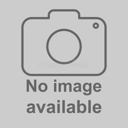

In [72]:
def download_image(url):
    return Image.open(requests.get(url, stream=True).raw)

download_image(df[nan_thumbnail_mask]['thumbnail'].iloc[0]).resize((128, 128))

### External Reference NaNs

External reference, is equivalent to the cadastral reference. It is the official and obligatory identifier of the real estate. It consists of an alphanumeric code that is assigned by the Cadastre so that every property must have a single cadastral reference that allows it to be placed unequivocally in the cadastral cartography.

In [73]:
df.externalReference.unique()

array(['AL_Sants', 'AB1508007-1', 'CB_BCN_0286_A', ..., 'Prinalv',
       'Z-02170-AG', 'A5333'], dtype=object)

In [74]:
print(f'External Reference NaNs are {df.externalReference.isna().sum()} out of {df.shape[0]} rows')

External Reference NaNs are 1671 out of 9974 rows


Surprisingly, we have a lot of NaNs, around a 20% of the rows contain a NaN. 

Actually, this column is not statistically meaningful and by now, a unique identifier, does not provide any valuable insight.

Therefore, we think that drop this column is the best way to handle these NaNs.

In [75]:
df.drop('externalReference', axis='columns', inplace=True)

In a future, in case we need more data, we will go back here and keep this coloumn to perform web scrapping and retrieve more information.

### Floor NaNs

The floor field determines in which floor is the flat or apartment.

We expect some NaNs because chalets and or houses do not have a "floor", they are in the ground.

In [76]:
print(f'Floor NaNs are {df.floor.isna().sum()} out of {df.shape[0]} rows')

Floor NaNs are 928 out of 9974 rows


In [77]:
df.propertyType.value_counts()

flat            8402
penthouse        587
chalet           404
studio           334
duplex           236
countryHouse      11
Name: propertyType, dtype: int64

In [78]:
for pt in df.propertyType.unique():
    pt_nan = df[df.propertyType == pt].floor.isna().sum()
    percentage = float(pt_nan) / df[df.propertyType == pt].shape[0]
    print(f'Property type {pt} has {pt_nan} floor NaN, '
          f'which represents a {int(percentage * 100)}%')

Property type flat has 494 floor NaN, which represents a 5%
Property type studio has 10 floor NaN, which represents a 2%
Property type duplex has 11 floor NaN, which represents a 4%
Property type penthouse has 31 floor NaN, which represents a 5%
Property type chalet has 375 floor NaN, which represents a 92%
Property type countryHouse has 7 floor NaN, which represents a 63%


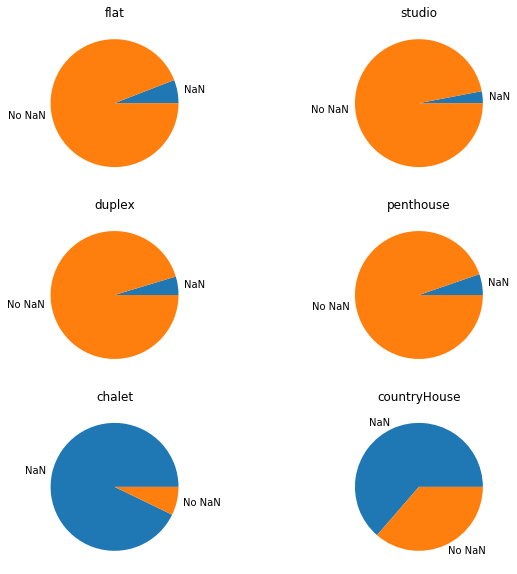

In [79]:
plt.figure(figsize=(10, 10))
for i, pt in enumerate(df.propertyType.unique(), start=1):
    plt.subplot(3, 2, i)
    pt_nan = df[df.propertyType == pt].floor.isna().sum()
    percentage = float(pt_nan) / df[df.propertyType == pt].shape[0]
    plt.pie([percentage, 1 - percentage], 
            labels=['NaN', 'No NaN'])
    plt.title(pt)
plt.show()

As expected, for Chalets and Country Houses we have a lot of NaNs, meaning that they are at the "ground".

For Country Houses we expect that all are at `bj`, therefore in this case, we fill the NaNs with bj

In [80]:
df.loc[(df.propertyType == 'countryHouse') & df.floor.isna(), 'floor'] = 'bj'

The same happens for chalets

In [81]:
df.loc[(df.propertyType == 'chalet') & df.floor.isna(), 'floor'] = 'bj'

On the other hand, for the remaining property types, we should not have NaNs because a floor seems mandatory. to avoid removing data records, we keep this NaNs, but remaining them to `unknown` because the flat has actually a floor but it is unknown for the people who is visiting idealista.

In [82]:
df['floor'].fillna('', inplace=True)

### District NaNs



In [96]:
df[~df.district.isna()].iloc[0].values

array(['88707408',
       'https://img3.idealista.com/blur/WEB_LISTING/0/id.pro.es.image.master/38/94/71/753258284.jpg',
       18, '3', 1050.0, 'flat', 'rent', 50.0, True, 1, 1,
       'Calle de Sants, 208', 'Barcelona', 'Barcelona', 'Sants-Montjuïc',
       'es', 'Sants', 41.3756551, 2.1312542, True,
       'https://www.idealista.com/inmueble/88707408/', '4876', False,
       'good', False, True, 21.0, False, False, False, False, 'flat',
       'Sants, Barcelona', 'Piso en Calle de Sants, 208', False, False,
       nan, nan, nan, 'Barna'], dtype=object)

In [83]:
df['parkingSpace_hasParkingSpace'].fillna(False, inplace=True)
df.head()

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,detailedType_subTypology,parkingSpace_parkingSpacePrice,newDevelopmentFinished,spain_state
0,88707408,https://img3.idealista.com/blur/WEB_LISTING/0/...,18,3,1050.0,flat,rent,50.0,True,1,...,False,flat,"Sants, Barcelona","Piso en Calle de Sants, 208",False,NaN,NaN,NaN,NaN,Barna
1,90050445,https://img3.idealista.com/blur/WEB_LISTING/0/...,13,5,3000.0,flat,rent,170.0,True,5,...,False,flat,"Pedralbes, Barcelona",Piso en Avenida Diagonal,True,True,NaN,NaN,NaN,Barna
2,89790054,https://img3.idealista.com/blur/WEB_LISTING/0/...,17,4,1050.0,flat,rent,75.0,True,2,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Piso en Calle del Comandant Benítez,False,NaN,NaN,NaN,NaN,Barna
3,89813394,https://img3.idealista.com/blur/WEB_LISTING/0/...,16,3,780.0,studio,rent,36.0,True,0,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Estudio,False,NaN,studio,NaN,NaN,Barna
4,90050238,https://img3.idealista.com/blur/WEB_LISTING/0/...,14,1,725.0,flat,rent,65.0,True,2,...,False,flat,"Sant Ildefons, Cornellà de Llobregat",Piso en boix,False,NaN,NaN,NaN,NaN,Barna


In [84]:
has_parking_mask = (~df.parkingSpace_hasParkingSpace.isna()) & df.parkingSpace_hasParkingSpace
df.loc[has_parking_mask & df.parkingSpace_isParkingSpaceIncludedInPrice, 'parkingSpace_parkingSpacePrice'] = 0
#df.loc[has_parking_mask & df.parkingSpace_isParkingSpaceIncludedInPrice].parkingSpace_parkingSpacePrice = 0

df.head()

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,detailedType_subTypology,parkingSpace_parkingSpacePrice,newDevelopmentFinished,spain_state
0,88707408,https://img3.idealista.com/blur/WEB_LISTING/0/...,18,3,1050.0,flat,rent,50.0,True,1,...,False,flat,"Sants, Barcelona","Piso en Calle de Sants, 208",False,NaN,NaN,NaN,NaN,Barna
1,90050445,https://img3.idealista.com/blur/WEB_LISTING/0/...,13,5,3000.0,flat,rent,170.0,True,5,...,False,flat,"Pedralbes, Barcelona",Piso en Avenida Diagonal,True,True,NaN,0.0,NaN,Barna
2,89790054,https://img3.idealista.com/blur/WEB_LISTING/0/...,17,4,1050.0,flat,rent,75.0,True,2,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Piso en Calle del Comandant Benítez,False,NaN,NaN,NaN,NaN,Barna
3,89813394,https://img3.idealista.com/blur/WEB_LISTING/0/...,16,3,780.0,studio,rent,36.0,True,0,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Estudio,False,NaN,studio,NaN,NaN,Barna
4,90050238,https://img3.idealista.com/blur/WEB_LISTING/0/...,14,1,725.0,flat,rent,65.0,True,2,...,False,flat,"Sant Ildefons, Cornellà de Llobregat",Piso en boix,False,NaN,NaN,NaN,NaN,Barna


In [85]:
df['parkingSpace_isParkingSpaceIncludedInPrice'].fillna(False, inplace=True)
# df['detailedType_subTypology'].fillna("unknown", inplace=True)
# df['externalReference'].fillna('', inplace=True)
# df['floor'].fillna('', inplace=True)
df.head()

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,detailedType_subTypology,parkingSpace_parkingSpacePrice,newDevelopmentFinished,spain_state
0,88707408,https://img3.idealista.com/blur/WEB_LISTING/0/...,18,3,1050.0,flat,rent,50.0,True,1,...,False,flat,"Sants, Barcelona","Piso en Calle de Sants, 208",False,False,NaN,NaN,NaN,Barna
1,90050445,https://img3.idealista.com/blur/WEB_LISTING/0/...,13,5,3000.0,flat,rent,170.0,True,5,...,False,flat,"Pedralbes, Barcelona",Piso en Avenida Diagonal,True,True,NaN,0.0,NaN,Barna
2,89790054,https://img3.idealista.com/blur/WEB_LISTING/0/...,17,4,1050.0,flat,rent,75.0,True,2,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Piso en Calle del Comandant Benítez,False,False,NaN,NaN,NaN,Barna
3,89813394,https://img3.idealista.com/blur/WEB_LISTING/0/...,16,3,780.0,studio,rent,36.0,True,0,...,False,flat,"La Maternitat i Sant Ramon, Barcelona",Estudio,False,False,studio,NaN,NaN,Barna
4,90050238,https://img3.idealista.com/blur/WEB_LISTING/0/...,14,1,725.0,flat,rent,65.0,True,2,...,False,flat,"Sant Ildefons, Cornellà de Llobregat",Piso en boix,False,False,NaN,NaN,NaN,Barna


In [86]:
df.isna().any(0)

propertyCode                                  False
thumbnail                                     False
numPhotos                                     False
floor                                         False
price                                         False
propertyType                                  False
operation                                     False
size                                          False
exterior                                      False
rooms                                         False
bathrooms                                     False
address                                       False
province                                      False
municipality                                  False
district                                       True
country                                       False
neighborhood                                   True
latitude                                      False
longitude                                     False
showAddress 

In [87]:
df[df.floor.isna() & (df.propertyType =='flat')].shape

(0, 40)